In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
% matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# from hcnn.crchcnn import CRCHCNN
from hcnn.committee import CRCHCNNCommittee
from hcnn.loss_functions import LogCosh

# Synthetic data

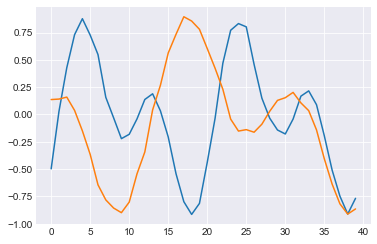

In [15]:
def sample_data(sample_size, signal_freq=60):
    import random
    def sine(X, signal_freq=60.):
        return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0

    def noisy(Y, noise_range=(-0.05, 0.05)):
        noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
        return Y + noise

    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    Y = noisy(sine(X + random_offset, signal_freq))
    return Y

# data = sample_data(60, 20).reshape(-1, 1)
data = np.array([sample_data(40, 20), sample_data(40, 30)]).T
plt.plot(data)

In [17]:
n_estimators = 10
committee = CRCHCNNCommittee(
    data_dim=data.shape[1], 
    hidden_dim=20, 
    weight_std=0.2, 
    forecast_horizon=data.shape[0], 
    n_estimators=n_estimators
)

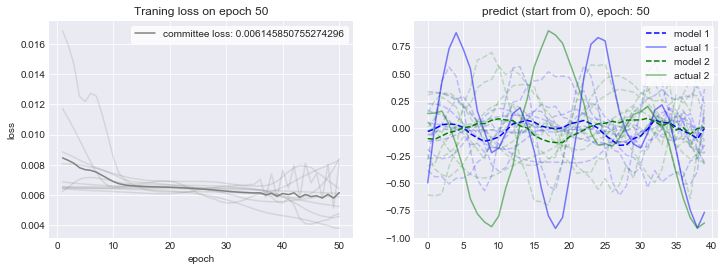

In [18]:
train_loss = committee.train(data, lr=0.001, epochs=50, plot_loss=False, plot_pred_train=True)

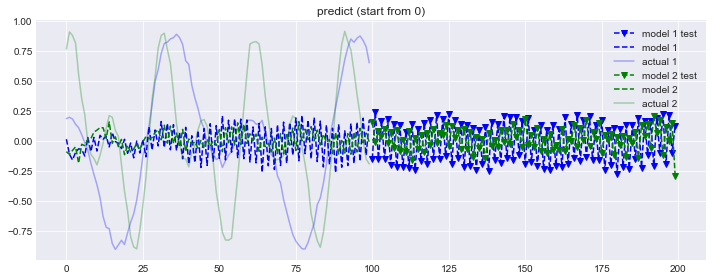

In [8]:
y_pred = committee.sample(on_train=True)[0]
y_pred_test = committee.sample()[0]

# PLOT forecast of diffs
fig, ax = plt.subplots(figsize=(10, 4))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
    ax.plot(np.arange(y_pred_test.shape[0]) + data.shape[0], y_pred_test[:, c], 'v--', label=f'model {c+1} test', color=colors[c], alpha=1)
    ax.plot(y_pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
    ax.plot(data[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
ax.legend()
plt.tight_layout()

# Airline passengers data

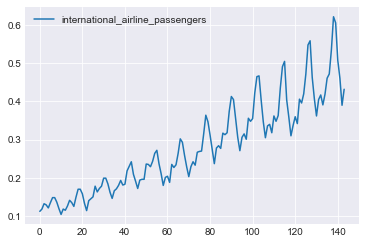

In [19]:
df = pd.read_csv('../data/international-airline-passengers.csv', index_col=0)
df.index = range(0, len(df))
df /= 1000
df.plot()

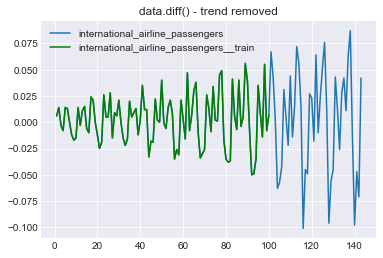

In [20]:
data = df.diff()  # remove trend
data = data.iloc[1:]
train_test_split_index = 100
data_train = data[:train_test_split_index]

fig, ax = plt.subplots()
data.plot(ax=ax, title='data.diff() - trend removed')
data_train.rename(columns={c:'{}__train'.format(c) for c in data_train.columns}).plot(ax=ax, color='g')
plt.show()

In [21]:
n_estimators = 10
committee = CRCHCNNCommittee(
    data_dim=data.shape[1], 
    hidden_dim=20, 
    weight_std=0.2, 
    forecast_horizon=data_train.shape[0], 
    n_estimators=n_estimators
)

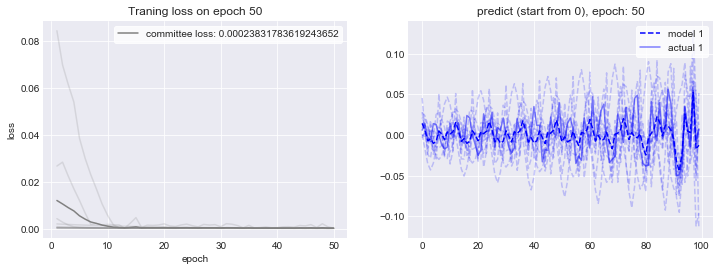

In [22]:
train_loss = committee.train(
    data_train.values, 
    lr=0.001, 
    epochs=50, 
    criterion=LogCosh.apply, 
    plot_loss=False, 
    plot_pred_train=True
)

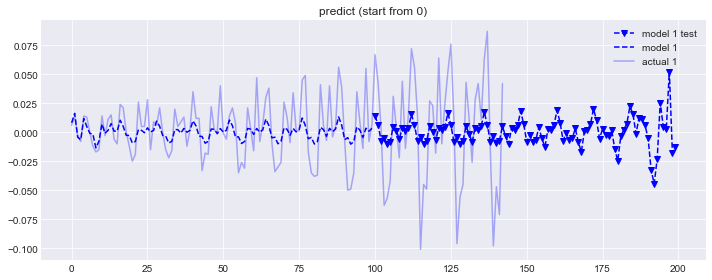

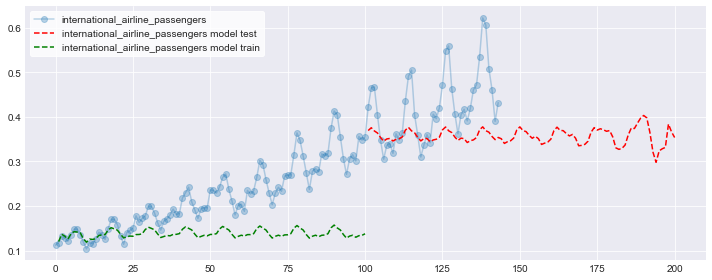

In [23]:
y_pred = committee.sample(on_train=True)[0]
y_pred_test = committee.sample()[0]

# PLOT forecast of diffs
fig, ax = plt.subplots(figsize=(10, 4))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
    ax.plot(np.arange(y_pred_test.shape[0]) + data_train.shape[0], y_pred_test[:, c], 'v--', label=f'model {c+1} test', color=colors[c], alpha=1)
    ax.plot(y_pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
    ax.plot(data.values[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
ax.legend()
plt.tight_layout()

# PLOT FORECAST after diff inverse transform
def diff_inverse_transform(df, first_row):
    df_ = first_row
    for i in range(df.shape[0]):
        row = pd.DataFrame(data=df.iloc[[i]].values + df_.iloc[[i]].values, 
                           columns=df.columns, index=df.iloc[[i]].index)
        df_ = df_.append(row)
    return df_.iloc[1:]

y_pred_test = pd.DataFrame(data=y_pred_test, columns=df.columns)#.rename('forecast from the end of train'])
y_pred_test.index = np.arange(data_train.index[-1]+1, data_train.index[-1]+1+committee.forecast_horizon)
df_forecast_test = diff_inverse_transform(y_pred_test, df.loc[[data_train.index[-1]]])
df_forecast_test.rename(columns={c: '{} model test'.format(c) for c in df_forecast_test.columns}, inplace=True)

y_pred = pd.DataFrame(data=y_pred, columns=df.columns, index=np.arange(data_train.index[0], data_train.index[0]+committee.forecast_horizon)) # columns=['forecast from the start']
df_forecast = diff_inverse_transform(y_pred, df.loc[[0]])
df_forecast.rename(columns={c: '{} model train'.format(c) for c in df_forecast.columns}, inplace=True)
    
fig, ax = plt.subplots(figsize=(10, 4))
df.plot(ax=ax, style='o-', alpha=0.3)
df_forecast_test.plot(ax=ax, style='r--')
df_forecast.plot(ax=ax, style='g--')
legend_pred = ax.legend(frameon=True, loc='upper left')
legend_pred.get_frame().set_color('white')
plt.tight_layout()